In [1]:
!nvidia-smi

Sun Nov 19 22:23:28 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.01                 Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   37C    P8              N/A / 115W |    440MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import pathlib
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.config.experimental.set_virtual_device_configuration(
    physical_devices[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*15)])

In [5]:
IMG_SIZE=(720,480)
batch_size = 32
channels = 3
epochs = 10

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data_temp/",
    shuffle=True,
    image_size = IMG_SIZE,
    batch_size = batch_size
    )

Found 3804 files belonging to 19 classes.


In [7]:
class_names = dataset.class_names
# class_names

In [8]:
# # Count the number of images in each class
# class_counts = []
# for class_name in class_names:
#     class_dir = pathlib.Path("data_temp/") / class_name
#     num_images = len(list(class_dir.glob('*')))
#     class_counts.append(num_images)
    
# class_weights = {}
# for class_idx in range(len(class_counts)):
#   if class_counts[class_idx] != 0:
#     class_weights[class_idx] = total_samples / (class_counts[class_idx] * len(class_counts))

# for class_idx in range(len(class_names)):
#   print(f"{class_names[class_idx]}: {class_counts[class_idx]}")

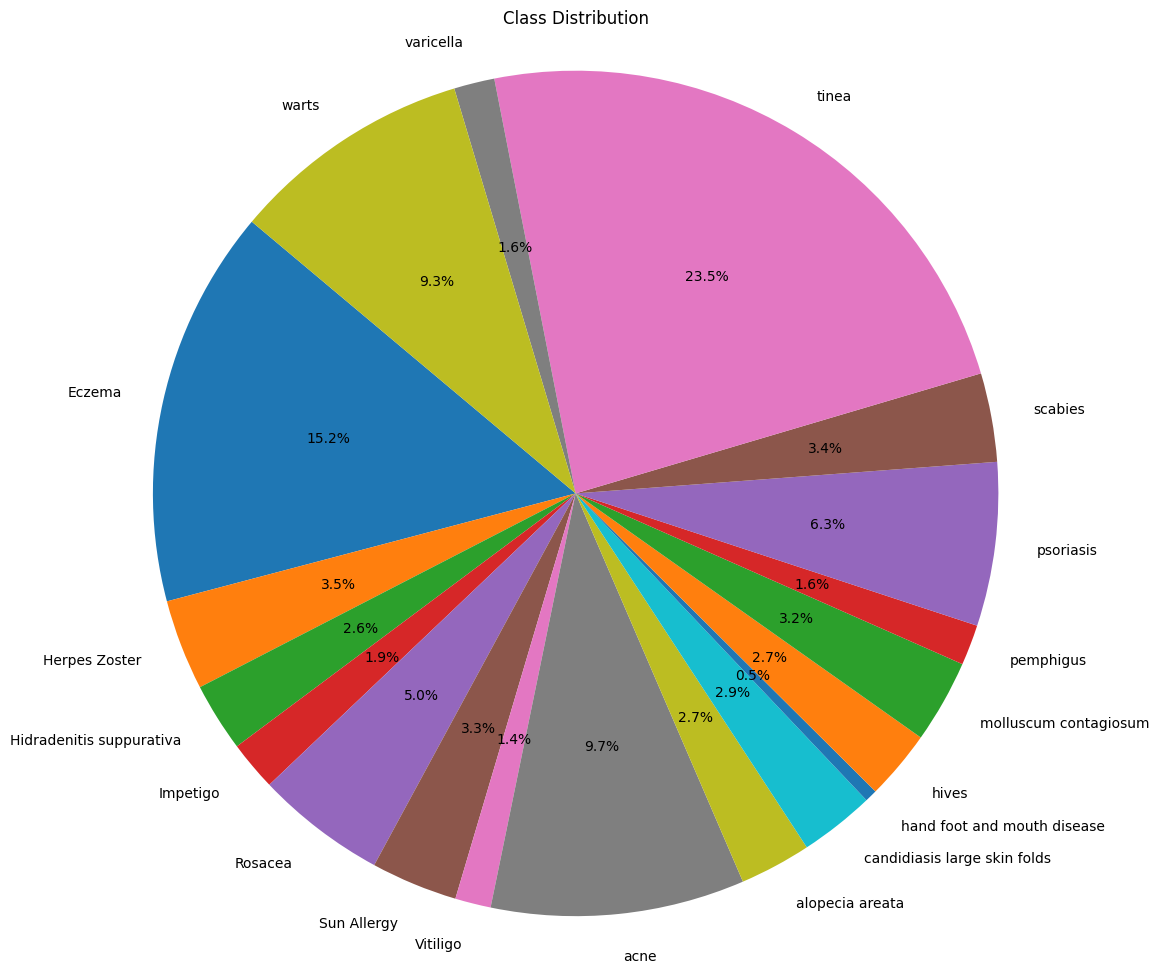

In [9]:
# Count the number of images in each class
class_counts = []
for class_name in class_names:
    class_dir = pathlib.Path("data_temp/") / class_name
    num_images = len(list(class_dir.glob('*')))
    class_counts.append(num_images)

# Plot a pie chart for class distribution
plt.figure(figsize=(12, 12))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2,shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)


    return train_ds, val_ds

In [11]:
train_ds, val_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

95

In [13]:
len(val_ds)

23

In [14]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
base_model =tf.keras.applications.EfficientNetB5(include_top=False,
                                                    weights='imagenet'
                                                   )
    
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(720, 480, 3), name="input_layer")
x = base_model(inputs,training=False)
x = layers.GlobalAveragePooling2D(name="GloPool")(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(19, activation="softmax", name="output_layer")(x)
model_0 = tf.keras.Model(inputs, outputs)
model_0.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

In [16]:
train_ds = train_ds.map(lambda x, y: (tf.keras.applications.efficientnet.preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (tf.keras.applications.efficientnet.preprocess_input(x), y))

In [17]:
# Calculate class weights based on class distribution
total_samples = sum(class_counts)
class_weights = {class_idx: total_samples / (class_counts[class_idx] * len(class_counts)) for class_idx in range(len(class_counts))}
# Define a custom callback to set class weights during training
class WeightedLossCallback(tf.keras.callbacks.Callback):
    def __init__(self, class_weights):
        super(WeightedLossCallback, self).__init__()
        self.class_weights = class_weights

    def on_epoch_begin(self, epoch, logs=None):
        self.model.loss_weights = [self.class_weights]

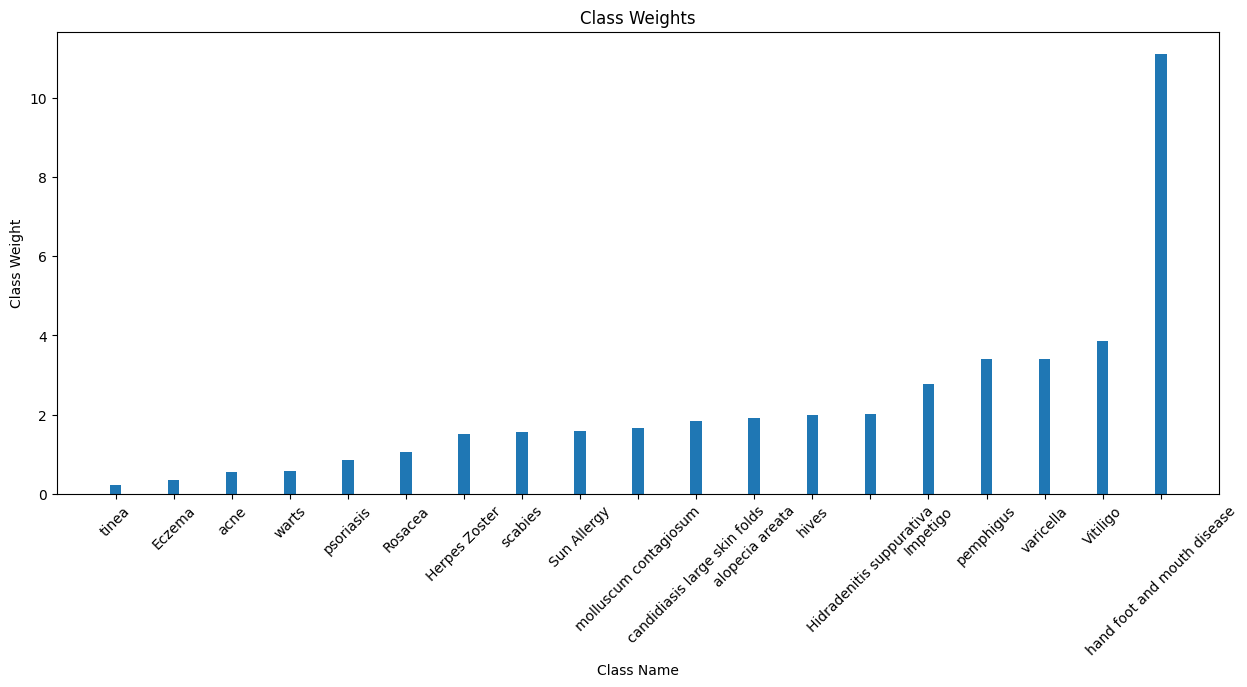

In [18]:
class_weights = {}
for class_idx in range(len(class_counts)):
    if class_counts[class_idx] != 0:
        class_weights[class_names[class_idx]] = total_samples / (class_counts[class_idx] * len(class_counts))

# for class_idx in range(len(class_names)):
#   print(f"{class_names[class_idx]}: {class_weights[class_idx]}")

# Convert the dictionary to a list of tuples for sorting and extracting class names and weights
# Sort the class names and weights based on class weights
sorted_class_names = sorted(class_weights, key=class_weights.get)
sorted_weights = [class_weights[class_name] for class_name in sorted_class_names]

plt.figure(figsize=(15, 6))
plt.bar(sorted_class_names, sorted_weights, width=0.2)
plt.xlabel("Class Name")
plt.ylabel("Class Weight")
plt.title("Class Weights")
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()

In [19]:
history = model_0.fit(train_ds,
           epochs=100,
           steps_per_epoch=len(train_ds),
           validation_data=val_ds,
           validation_steps=int(0.25*len(val_ds))
            , callbacks=[WeightedLossCallback(class_weights)]
)
           # , callbacks=[WeightedLossCallback(class_weights)]

Epoch 1/100
95/95 [==============================] - 200s 2s/step - loss: 2.2109 - accuracy: 0.3376 - val_loss: 1.8929 - val_accuracy: 0.3875
Epoch 2/100
95/95 [==============================] - 134s 1s/step - loss: 1.7300 - accuracy: 0.4601 - val_loss: 1.4637 - val_accuracy: 0.5312
Epoch 3/100
95/95 [==============================] - 116s 1s/step - loss: 1.5174 - accuracy: 0.5306 - val_loss: 1.3127 - val_accuracy: 0.6250
Epoch 4/100
95/95 [==============================] - 119s 1s/step - loss: 1.3609 - accuracy: 0.5771 - val_loss: 1.2004 - val_accuracy: 0.6438
Epoch 5/100
95/95 [==============================] - 113s 1s/step - loss: 1.2654 - accuracy: 0.6038 - val_loss: 1.1503 - val_accuracy: 0.6500
Epoch 6/100
95/95 [==============================] - 130s 1s/step - loss: 1.1518 - accuracy: 0.6453 - val_loss: 1.0586 - val_accuracy: 0.6938
Epoch 7/100
95/95 [==============================] - 192s 2s/step - loss: 1.0946 - accuracy: 0.6640 - val_loss: 1.0602 - val_accuracy: 0.7063
Epoch 

In [20]:
scores = model_0.evaluate(val_ds)

23/23 [==============================] - 45s 2s/step - loss: 0.1853 - accuracy: 0.9592


In [21]:
scores

[0.18534593284130096, 0.95923912525177]

In [22]:
history

In [23]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 95}

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
history.history['accuracy']

[0.3376152813434601,
 0.46014493703842163,
 0.5306324362754822,
 0.5770751237869263,
 0.6037549376487732,
 0.6452569365501404,
 0.6640316247940063,
 0.6808300614356995,
 0.698616623878479,
 0.717391312122345,
 0.7388010621070862,
 0.7595520615577698,
 0.7671278119087219,
 0.7862318754196167,
 0.7931488752365112,
 0.7964426875114441,
 0.8178524374961853,
 0.8287220001220703,
 0.8333333134651184,
 0.8372858762741089,
 0.854084312915802,
 0.8623188138008118,
 0.8626482486724854,
 0.8689064383506775,
 0.875823438167572,
 0.8899868130683899,
 0.8913043737411499,
 0.9001976251602173,
 0.9110671877861023,
 0.9071146249771118,
 0.9100790619850159,
 0.9156785011291504,
 0.9163373112678528,
 0.9212779998779297,
 0.9298418760299683,
 0.9301712512969971,
 0.9324769377708435,
 0.9413702487945557,
 0.9440052509307861,
 0.9397233128547668,
 0.9469696879386902,
 0.950263500213623,
 0.9522398114204407,
 0.9558629989624023,
 0.9568511247634888,
 0.9561923742294312,
 0.9683794379234314,
 0.97167325019836

In [26]:
len(history.history['accuracy'])

100

In [27]:
epochs = 100
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

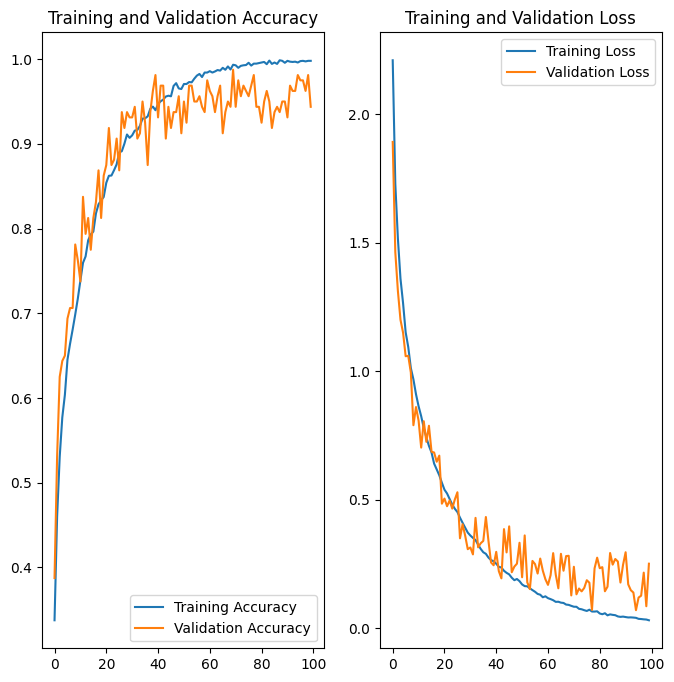

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual label: warts
1/1 [==============================] - 3s 3s/step
Predicted Label warts


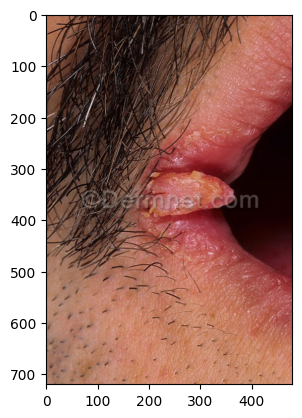

In [29]:
for images_batch, label_batch in val_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])

    batch_prediction = model_0.predict(images_batch)
    print("Predicted Label",class_names[np.argmax(batch_prediction[0])])

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 41ms/step


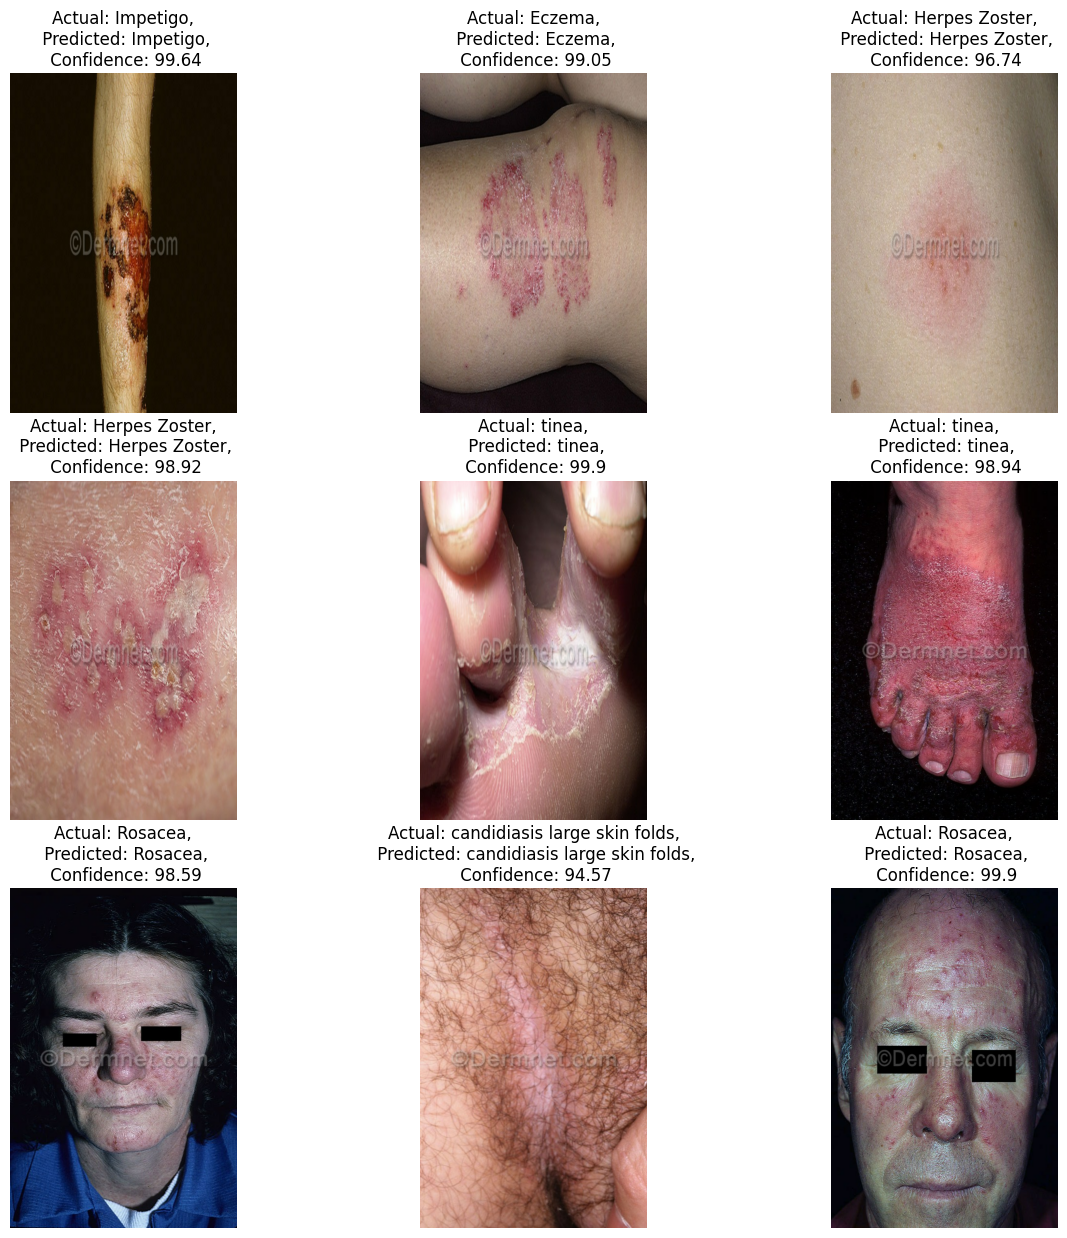

In [31]:
plt.figure(figsize=(15,15))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model_0, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f'Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}')

        plt.axis("off")

In [32]:
model_0.save("19 most common skin lesions classification Model.h5") 

In [33]:
# Make predictions with model
preds_probs = model_0.predict(val_ds, verbose=1) # set verbosity to see how long is left

23/23 [==============================] - 46s 2s/step


In [34]:
len(val_ds)

23

In [35]:
# How many predictions are there?
len(preds_probs)
     

736

In [36]:
# What's the shape of our predictions?
preds_probs.shape

(736, 19)

In [37]:
# Let's see what the first 10 predictions look like
preds_probs[:5]
     

array([[6.5760678e-01, 1.5927820e-07, 8.5183324e-08, 5.8934692e-08,
        7.3017640e-05, 4.8035703e-04, 3.1657552e-04, 7.6525803e-06,
        9.3688783e-08, 2.6101941e-07, 2.6410415e-08, 1.6247471e-07,
        9.0979876e-07, 2.2845716e-08, 6.7958185e-06, 2.4375007e-03,
        3.3906865e-01, 3.2025735e-08, 8.5774047e-07],
       [9.9990451e-01, 2.8029868e-07, 3.6672429e-06, 2.2963992e-08,
        1.4342870e-08, 1.3245841e-07, 2.6953899e-07, 1.2833652e-06,
        5.3571600e-08, 1.5969552e-07, 8.5276115e-06, 5.5489746e-08,
        9.6610071e-09, 1.3361804e-09, 4.8359986e-08, 7.3424708e-05,
        6.7978904e-06, 2.5759787e-08, 8.1211448e-07],
       [3.6543329e-06, 8.5677071e-05, 9.9922788e-01, 7.4907639e-06,
        4.9773599e-09, 3.8944989e-09, 4.3731713e-08, 1.0173336e-04,
        6.8271166e-11, 2.4245081e-04, 4.8937182e-10, 1.7667919e-09,
        1.8804237e-10, 3.3061378e-04, 8.1924433e-08, 1.3624279e-07,
        7.9437207e-08, 5.0743417e-08, 5.6240866e-11],
       [1.1477734e-08,

In [38]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([6.5760678e-01, 1.5927820e-07, 8.5183324e-08, 5.8934692e-08,
        7.3017640e-05, 4.8035703e-04, 3.1657552e-04, 7.6525803e-06,
        9.3688783e-08, 2.6101941e-07, 2.6410415e-08, 1.6247471e-07,
        9.0979876e-07, 2.2845716e-08, 6.7958185e-06, 2.4375007e-03,
        3.3906865e-01, 3.2025735e-08, 8.5774047e-07], dtype=float32),
 19,
 1.0000000004684555)

In [39]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 19
What prediction probability sample 0 looks like:
 [6.5760678e-01 1.5927820e-07 8.5183324e-08 5.8934692e-08 7.3017640e-05
 4.8035703e-04 3.1657552e-04 7.6525803e-06 9.3688783e-08 2.6101941e-07
 2.6410415e-08 1.6247471e-07 9.0979876e-07 2.2845716e-08 6.7958185e-06
 2.4375007e-03 3.3906865e-01 3.2025735e-08 8.5774047e-07]
The class with the highest predicted probability by the model for sample 0: 0


In [40]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  2,  7,  4, 14, 18, 11, 16, 16], dtype=int64)

In [41]:
# Create a list to store class labels for each image
class_labels = []

# Iterate through the dataset to assign class names to images
for images, labels in dataset.unbatch():
    # Find the class index using argmax if it's in one-hot format
    class_index = labels.numpy().argmax() if len(labels.numpy().shape) > 1 else int(labels.numpy())

    # Get the class name using the class index
    class_label = class_names[class_index]

    # Append the class label to the list
    class_labels.append(class_label)

In [42]:
class_labels[20]

'acne'

In [43]:
# To get our test labels we need to unravel our val_data BatchDataset (Unbatch dataset)
y_labels = []
for images, labels in val_ds.unbatch():
    # Get the index of the maximum value in the label tensor
    non_zero_indices = np.where(labels)[0]
    if non_zero_indices:
        label_value = non_zero_indices[0]
        y_labels.append(label_value)
    # print(f"Label: {label_value}")

y_labels[:10]# currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index va

[]

In [44]:
# Look at the first 10
y_labels[:10]

[]

In [45]:
# How many y_labels are there?
len(y_labels)

0

In [46]:
# import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# model.save(f"../models/{model_version}")